In [1]:
%matplotlib inline
import os
import math 
import numpy as np
import pandas as pd 
import seaborn as sns
import random
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from scipy.stats import pearsonr, spearmanr, gaussian_kde
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import scale
from statsmodels.sandbox.stats.multicomp import fdrcorrection0
from matplotlib.colors import rgb2hex
import warnings
sns.set_style('white')
pd.options.display.max_rows = 2000
pd.options.display.max_columns = 999
warnings.filterwarnings('ignore')

ahba_dir     = '/Users/kanaaax/Google Drive/TS-EUROTRAIN/RESULTS_QSMv3/dataframes/AHBA/'
gsea_dir     = '/Users/kanaaax/Desktop/GSEA'
permute_dir  = '/Users/kanaaax/Google Drive/TS-EUROTRAIN/RESULTS_QSMv3/dataframes/permutations'
save_fig_dir = '/Users/kanaaax/Google Drive/TS-EUROTRAIN/Papers/2016_QSM_paper/Figures_python_v4'

# wells outside the striatal masks 
wells = [2371,       # AHBA claustrum, right
         2379,       # AHBA claustrum, left
         159226045,  # AHBA striatum -- out of mask
         160091500   # AHBA septal nuclei, left
         ] 
#housekeeping
drop_strings = ['coords_native', 'donor_names', 'struct_id', 'struct_name', 
                'top_struct', 'Mean', 'Median', 'PC1', 'PC2','PC3', ]


In [2]:
###########################################
# Read QSM stat maps
##########################################
MNI = pd.read_csv(os.path.join(ahba_dir,'QSM_TSTATS/MNI_NIFTI_VALUES_permute_10K_OCT2.csv'), index_col = 0 )

In [3]:
###########################################
# Read expression values of AHBA database  
###########################################
AHBA = pd.read_csv(os.path.join(ahba_dir, 'ahba_data', 'AHBA_20737.csv'), index_col = 0)

In [4]:
AHBA_REANNOT = pd.read_csv(os.path.join(ahba_dir, 'ahba_data', 'AHBA_reannot.csv'), index_col = 0)

In [5]:
background_genes = pd.read_csv(os.path.join(ahba_dir,'background_gene_list.txt'), sep='\t').GeneSymbol.values
AHBA_BACK = AHBA_REANNOT.drop([i for i in AHBA_REANNOT.columns if i not in background_genes], axis = 1 )
AHBA_BACK = AHBA_BACK.drop([i for i in AHBA_BACK.index if i not in MNI.STR3_MOTOR_tstat_CP_1mm.dropna()],axis =0)
AHBA_BACK.to_csv(os.path.join(ahba_dir, 'ahba_data', 'AHBA_reannotBackground.csv'))

In [25]:
AHBA_BACK.shape

(62, 15745)

In [24]:
MNI.STR3_MOTOR_tstat_CP_1mm.dropna().shape

(62,)

(62,)

In [22]:
AHBA_REANNOT.shape

(3702, 20280)

In [183]:
# create qsm t-stat dataframe
chi = pd.DataFrame(MNI[nucleus].drop(wells, axis =0)).dropna().sort_index()

# Create AHBA dataframe 
genes = AHBA_REANNOT.columns[:-13]
ahba  = AHBA_REANNOT.drop([i for i in AHBA_REANNOT.index if i not in chi.index], axis=0).sort_index()
ahba  = ahba.drop([i for i in ahba.columns if i not in genes], axis=1)
# Z-Score
ahba = (ahba - ahba.mean())/ahba.std()


In [184]:
genes

Index([u'A1BG', u'A1BG-AS1', u'A1CF', u'A2M', u'A2ML1', u'A3GALT2', u'A4GALT',
       u'A4GNT', u'AAAS', u'AACS',
       ...
       u'ZWILCH', u'ZWINT', u'ZXDA', u'ZXDB', u'ZXDC', u'ZYG11A', u'ZYG11B',
       u'ZYX', u'ZZEF1', u'ZZZ3'],
      dtype='object', length=20267)

In [185]:
df_rvals = pd.DataFrame(index = genes, columns=['rval'])
for gene in genes:
    df_rvals.loc[gene]['rval']  = pearsonr(chi[nucleus], ahba[gene])[0]

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [186]:
print chi['STR3_MOTOR_tstat_CP_1mm'].shape
print ahba['A1BG'].shape

(58,)
(58,)


In [187]:
def make_rank_files(nucleus, AHBA_DF, corr_type = 'pearson'):
    
    ###############################
    # Creates preranked tables
    # This is a 2x20737 matrix with gene names for col1 and R-values or PLS1 for col2
    # R-values represent the association between gene-expression leves and t-statistical susceptibility difference 
    # PLS1 represents the linear combincation of the weighted gene expression scores 
    
    # Correlations implements Pearson or Spearman correlation between gene expression and t-stat 
    # PLS implements sklearn PLS-R where the full AHBA matrix (20737 genes) are the predictor variables (X) 
    # and the t-stat of voxel specific qsm t-stat difference is the response variable. 
    ################################
    
    # create qsm t-stat dataframe
    chi = pd.DataFrame(MNI[nucleus].drop(wells, axis =0)).dropna().sort_index()
    
    # Create AHBA dataframe 
    genes = AHBA_DF.columns[:-13]
    ahba  = AHBA_DF.drop([i for i in AHBA_DF.index if i not in chi.index], axis=0).sort_index()
    ahba  = ahba.drop([i for i in ahba.columns if i not in genes], axis=1)
    # Z-Score
    ahba = (ahba - ahba.mean())/ahba.std()
    
    
    if not os.path.isfile(os.path.join(gsea_dir, 'rank_files', '%s_%s.rnk' %(corr_type, nucleus))):
        # Make Correlation rank table 
        df_rvals = pd.DataFrame(index = genes, columns=['rval'])

        for gene in genes:
            if corr_type == 'pearson':
                df_rvals.loc[gene]['rval']  = pearsonr(chi[nucleus], ahba[gene])[0]
            elif corr_type == 'spearman':
                df_rvals.loc[gene]['rval']  = spearmanr(chi[nucleus], ahba[gene])[0]

        df_rvals = df_rvals.sort_values("rval", ascending=False)
        df_rvals.index.name = "Gene"
        df_rvals.to_csv(os.path.join(gsea_dir, 'rank_files', '%s_%s.rnk' %(corr_type, nucleus)), sep='\t')
        
    # Make PLS rank table
    pls = PLSRegression()
    fit = pls.fit(ahba, chi)
    
    df_pls = pd.DataFrame(index = genes, columns=['pls1'])
    df_pls.index.name = "Gene"
    df_pls['pls1'] = fit.x_weights_[:,0]
    df_pls.to_csv(os.path.join(gsea_dir, 'rank_files', 'pls_%s.rnk' %(nucleus)), sep='\t')
    
    return chi, fit

def run_gsea3(nucleus, gset, corr_type='pearson'):
    
    ################################
    # This code runs a Geneset enrichment analysis 
    # Gene Set Enrichment Analysis (GSEA) is a computational method 
    # that determines whether an a priori defined set of genes shows statistically 
    # significant, concordant differences between two biological states (e.g. phenotypes). 
    # https://software.broadinstitute.org/gsea/index.jsp
    ################################
    
    broadurl = 'gseaftp.broadinstitute.org://pub/gsea/gene_sets_final'
    gsets = {'GOALL' : '%s/c5.all.v6.2.symbols.gmt'%broadurl, 
             'KEGG'  : '%s/c2.cp.kegg.v6.2.symbols.gmt'%broadurl, 
             'REACTOME': '%s/c2.cp.reactome.v6.2.symbols.gmt'%broadurl, 
             'HALLMARK': '%s/h.all.v6.2.symbols.gmt'%broadurl, 
             'GOALLREACTOME': '%s/c2.cp.reactome.v6.2.symbols.gmt,%s/c5.all.v6.2.symbols.gmt'%(broadurl,broadurl),
             'GOALLKEGG': '%s/c2.cp.kegg.v6.2.symbols.gmt,%s/c5.all.v6.2.symbols.gmt'%(broadurl,broadurl),
             'GOALLREACTKEGG': '%s/c2.cp.kegg.v6.2.symbols.gmt,%s/c2.cp.reactome.v6.2.symbols.gmt,%s/c5.all.v6.2.symbols.gmt' %(broadurl,broadurl,broadurl)
            }
    
    rnk_file = os.path.join(os.path.join(gsea_dir, 'rank_files', '%s_%s.rnk' %(corr_type, nucleus)))
        
    print rnk_file
        
    if any(x.startswith('%s_%s_%s' %(nucleus, gset, corr_type)) for x in os.listdir(gsea_dir)):
        print "done ... %s_%s_%s" %(nucleus, gset, corr_type)
    
    else:
        gsea_cmd = ' '.join(['java -Xmx512m',
                '-cp ~/Desktop/gsea-3.0.jar xtools.gsea.GseaPreranked', 
                '-gmx ' + gsets[gset],
                '-norm meandiv -nperm 1000', 
                '-rnk '+ rnk_file,
                '-scoring_scheme weighted',
                '-rpt_label ' +  '%s_%s_%s' %(nucleus, gset, corr_type),
                '-create_svgs false',
                '-make_sets true',
                '-plot_top_x 20', 
                '-rnd_seed timestamp',
                '-set_max 500', 
                '-set_min 15',
                '-zip_report false',
                '-out ' + gsea_dir, 
                '-gui false',
                '> ' + os.path.join(gsea_dir, 'log_%s_%s_%s.txt'%(nucleus, gset, corr_type)) 
                             ])

        print '..... %s' %gsea_cmd
        os.system(gsea_cmd)

In [230]:
strm_qsm, strm_plsfit = make_rank_files('STR3_MOTOR_tstat_CP_1mm', AHBA_REANNOT)
str_qsm, str_plsfit = make_rank_files('STR_tstat_CP_1mm', AHBA_REANNOT)
strll_qsm, strll_plsfit = make_rank_files('STR_tstat_LL_1mm', AHBA_REANNOT)

KeyError: 'STR_tstat_LL_1mm'

In [204]:
strmLL_qsm, strmLL_plsfit = make_rank_files('STR3_MOTOR_tstat_LL_1mm', AHBA_REANNOT)

In [213]:
#for corr in [ 'pls']:
run_gsea3(nucleus = 'STR_tstat_CP_1mm', gset = 'GOALLREACTKEGG', corr_type='pls')
run_gsea3(nucleus = 'STR3_MOTOR_tstat_CP_1mm', gset = 'GOALLREACTKEGG', corr_type='pls')
run_gsea3(nucleus = 'STR3_MOTOR_tstat_LL_1mm', gset = 'GOALLREACTKEGG', corr_type='pls')


/Users/kanaaax/Desktop/GSEA/rank_files/pls_STR_tstat_CP_1mm.rnk
done ... STR_tstat_CP_1mm_GOALLREACTKEGG_pls
/Users/kanaaax/Desktop/GSEA/rank_files/pls_STR3_MOTOR_tstat_CP_1mm.rnk
done ... STR3_MOTOR_tstat_CP_1mm_GOALLREACTKEGG_pls
/Users/kanaaax/Desktop/GSEA/rank_files/pls_STR3_MOTOR_tstat_LL_1mm.rnk
..... java -Xmx512m -cp ~/Desktop/gsea-3.0.jar xtools.gsea.GseaPreranked -gmx gseaftp.broadinstitute.org://pub/gsea/gene_sets_final/c2.cp.kegg.v6.2.symbols.gmt,gseaftp.broadinstitute.org://pub/gsea/gene_sets_final/c2.cp.reactome.v6.2.symbols.gmt,gseaftp.broadinstitute.org://pub/gsea/gene_sets_final/c5.all.v6.2.symbols.gmt -norm meandiv -nperm 1000 -rnk /Users/kanaaax/Desktop/GSEA/rank_files/pls_STR3_MOTOR_tstat_LL_1mm.rnk -scoring_scheme weighted -rpt_label STR3_MOTOR_tstat_LL_1mm_GOALLREACTKEGG_pls -create_svgs false -make_sets true -plot_top_x 20 -rnd_seed timestamp -set_max 500 -set_min 15 -zip_report false -out /Users/kanaaax/Desktop/GSEA -gui false > /Users/kanaaax/Desktop/GSEA/log_S

In [203]:
run_gsea3(nucleus = 'STR3_MOTOR_tstat_CP_1mm', gset = 'GOALLREACTKEGG', corr_type='pearson')

/Users/kanaaax/Desktop/GSEA/rank_files/pearson_STR3_MOTOR_tstat_CP_1mm.rnk
..... java -Xmx512m -cp ~/Desktop/gsea-3.0.jar xtools.gsea.GseaPreranked -gmx gseaftp.broadinstitute.org://pub/gsea/gene_sets_final/c2.cp.kegg.v6.2.symbols.gmt,gseaftp.broadinstitute.org://pub/gsea/gene_sets_final/c2.cp.reactome.v6.2.symbols.gmt,gseaftp.broadinstitute.org://pub/gsea/gene_sets_final/c5.all.v6.2.symbols.gmt -norm meandiv -nperm 1000 -rnk /Users/kanaaax/Desktop/GSEA/rank_files/pearson_STR3_MOTOR_tstat_CP_1mm.rnk -scoring_scheme weighted -rpt_label STR3_MOTOR_tstat_CP_1mm_GOALLREACTKEGG_pearson -create_svgs false -make_sets true -plot_top_x 20 -rnd_seed timestamp -set_max 500 -set_min 15 -zip_report false -out /Users/kanaaax/Desktop/GSEA -gui false > /Users/kanaaax/Desktop/GSEA/log_STR3_MOTOR_tstat_CP_1mm_GOALLREACTKEGG_pearson.txt


In [9]:
def plot_pls(fit,qsm, ncomponent=0):
    print pearsonr(scale(fit.x_scores_[:, ncomponent]), qsm[qsm.columns[0]])
    sns.jointplot(scale(fit.x_scores_[:, ncomponent]), qsm[qsm.columns[0]], kind='reg', 
                 annot_kws=dict(stat="r"))

(-0.46713664191427323, 9.60780567824636e-07)


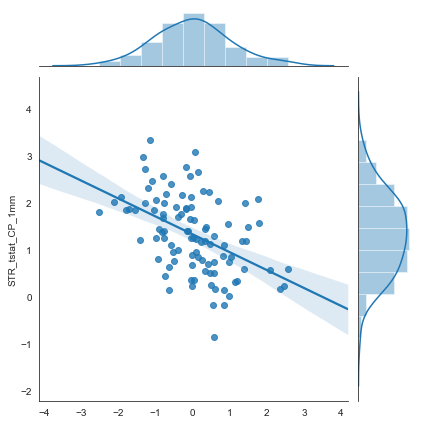

In [10]:
plot_pls(str_plsfit,str_qsm,0)

(0.644973767532749, 4.636056572534173e-08)


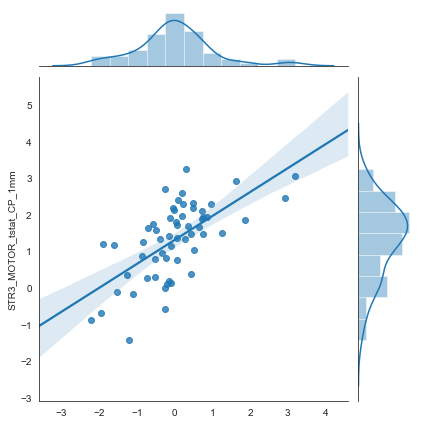

In [11]:
plot_pls(strm_plsfit,strm_qsm,0)

In [12]:
strm_plsfit.coef_

array([[4.15862101e-04],
       [2.44931478e-04],
       [1.18842300e-04],
       ...,
       [2.75771776e-04],
       [2.55834826e-04],
       [9.85227735e-05]])

In [13]:
def make_pls_rank(nucleus):
    
    ###############################
    # Creates preranked tables
    # This is a 2x20737 matrix with gene names for col1 and R-values or PLS1 for col2
    # R-values represent the association between gene-expression leves and t-statistical susceptibility difference 
    # PLS1 represents the linear combincation of the weighted gene expression scores 
    
    # Correlations implements Pearson or Spearman correlation between gene expression and t-stat 
    # PLS implements sklearn PLS-R where the full AHBA matrix (20737 genes) are the predictor variables (X) 
    # and the t-stat of voxel specific qsm t-stat difference is the response variable. 
    ################################
    
    # create qsm t-stat dataframe
    chi = pd.DataFrame(MNI[nucleus].drop(wells, axis =0)).dropna().sort_index()
    
    # Create AHBA dataframe 
    genes = AHBA.columns[:-28]
    ahba  = AHBA.drop([i for i in AHBA.index if i not in chi.index], axis=0).sort_index()
    ahba  = ahba.drop([i for i in ahba.columns if i not in genes], axis=1)
    # Z-Score
    ahba = (ahba - ahba.mean())/ahba.std()
    
    
    # Make PLS rank table
    pls = PLSRegression()
    fit = pls.fit(ahba, chi)
    
    df_pls = pd.DataFrame(index = genes, columns=['pls1'])
    df_pls.index.name = "Gene"
    df_pls['pls1'] = fit.x_weights_[:,0]
    df_pls.to_csv(os.path.join(gsea_dir, 'rank_files', 'pls_%s.rnk' %(nucleus)), sep='\t')
    
    return chi, fit


In [14]:
nucleus=['STR3_MOTOR_tstat_CP_1mm']

# create qsm t-stat dataframe
chi = pd.DataFrame(MNI[nucleus].drop(wells, axis =0)).dropna().sort_index()

# Create AHBA dataframe 
genes = AHBA.columns[:-28]
ahba  = AHBA.drop([i for i in AHBA.index if i not in chi.index], axis=0).sort_index()
ahba  = ahba.drop([i for i in ahba.columns if i not in genes], axis=1)
# Z-Score
ahba = (ahba - ahba.mean())/ahba.std()

# Make PLS rank table
pls = PLSRegression()
fit = pls.fit(ahba, chi)

df_pls = pd.DataFrame(index = genes, columns=['pls1'])
df_pls.index.name = "Gene"
df_pls['pls1'] = fit.x_weights_[:,0]

plsboot = pd.DataFrame(index = genes)


# Bootstrap over wells with resampling and run pls 1000 times 
# Zscore is the ratio of the PLS weight of each gene to its bootstrap Standard Error

for i in range(1000):
    ahba_boot = ahba.sample(n=len(ahba.index), replace=1, axis = 0)
    chi_boot = pd.DataFrame(index=ahba_boot.index, columns = nucleus)
    for b in chi_boot.index:
        chi_boot.loc[b,nucleus[0]]  = chi.loc[b][nucleus[0]] 
    
    pls = PLSRegression()
    fit = pls.fit(ahba_boot, chi_boot)
    plsboot['boot_%s'%i] = fit.x_weights_[:,0]
    
sem = plsboot.sem(axis=1)
df_pls['z'] = scale(df_pls['pls1'].values / sem)
df_pls['pls1z'] = scale(df_pls['pls1'].values)

In [15]:
#for i in df_pls.sort_values('pls1z')[-250:].index:
for i in df_pls.sort_values('pls1z')[:10].index:
    print i 

CXorf59
CD36
CXorf30
GLRA3
GRM7
DGKK
LRRC50
FAM74A4
TXLNB
OPRM1


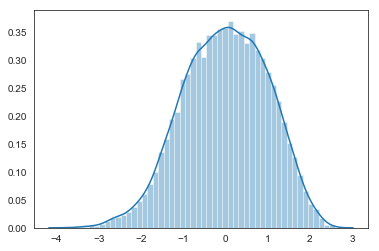

In [16]:
sns.distplot(scale(df_pls.pls1))

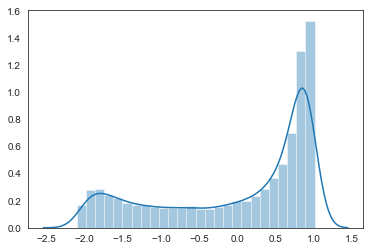

In [17]:
sns.distplot(scale(df_pls['pls1'].values / sem))

In [18]:
print len([i for i in scale(df_pls.pls1) if i >2])

232


In [19]:
pd.read_csv("/Users/kanaaax/Desktop/GSEA/rank_files/pearson_STR3_MOTOR_tstat_CP_1mm.rnk", 
            sep='\t').sort_values('rval')[0:5]

,Gene,rval
20736,CXorf59,-0.658511
20735,CD36,-0.651669
20734,CXorf30,-0.606297
20733,GLRA3,-0.596848
20732,GRM7,-0.593810


In [64]:
df_pls = pd.read_csv("/Users/kanaaax/Desktop/GSEA/rank_files/pls_STR3_MOTOR_tstat_CP_1mm.rnk", sep='\t').sort_values('pls1')
df_prs = pd.read_csv("/Users/kanaaax/Desktop/GSEA/rank_files/pearson_STR3_MOTOR_tstat_CP_1mm.rnk", sep='\t').sort_values('rval')

for i in df_prs['Gene'][:1].index:
    print df_prs.loc[i]['Gene']#, df_prs.loc[i]['rval']

CXorf59


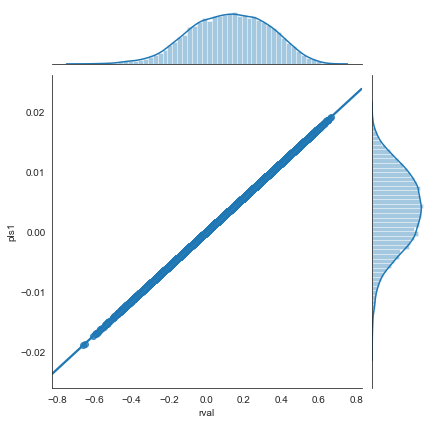

In [21]:
sns.jointplot(df_prs.rval, df_pls.pls1 , kind='reg', 
                 annot_kws=dict(stat="r"))

https://neuroimage.usc.edu/brainstorm/Tutorials/PLS
    
Partial Least Squares (PLS) analysis is a multivariate statistical technique that is used to find the relationship between two blocks of variables. PLS has various applications and types (Krishnan et al., 2011); however, the focus of this tutorial is on Mean-Centered PLS analysis, which is a common type of PLS while working with neuroimaging data. In this type of PLS analysis, one data block is neural activity (e.g. MEG measurements/source data here) while the other one is the experiment design (e.g. different groups/conditions).

PLS analysis is based on extracting the common information between the two data blocks by finding a correlation matrix and linear combinations of variables in both data blocks that have maximum covariance with one another. In the example provided here, we find a contrast between different conditions as well as patterns of brain activity that maximally covary with that specific contrast.

For this purpose, we take the neural activity as one data block, matrix X, where the rows of matrix X are observations (participants/trials) nested in conditions or groups, and the columns of X are variables (time scales nested within sources). The other data block, matrix Y, is a matrix of dummy coding that corresponds to experimental design (different groups or conditions) (Krishnan et al., 2011).

PLS analysis first calculates a mean-centered matrix using matrices X and Y. Then, singular value decomposition (SVD) is applied on the mean-centered matrix. The outcome of PLS analysis is a set of latent variables that are in fact linear combinations of initial variables of the two data blocks that maximally covary with the corresponding contrasts (Krishnan et al., 2011, Mišić et al., 2016). More specifically, each latent variable consists of a set of singular values that describe the effect size, as well as a set of singular vectors, or weights, that define the contribution of each initial variable to the latent variables (Mišić et al., 2016).

Finally, the statistical significance of a latent variable is defined by a p-value calculated from permutation test. In addition, bootstrapping is used to assess the reliability of each original variable (e.g. a source at a time point) that contributes to the latent variable. Bootstrap ratios are calculated for each original variable for this purpose. Bootstrap ratio is the ratio of the weights to the standard errors estimated from bootstrapping. Therefore, the larger the magnitude of a bootstrap ratio, the larger the weight (i.e. contribution to the latent variable) and the smaller the standard error (i.e. higher stability) (McIntosh and Lobaugh, 2004, Mišić et al., 2016). Bootstrap ratio can be equivalent to a z-score if we have an approximately normal bootstrap distribution (Efron and Tibshirani, 1986).

PLS analysis was explained in general in this section. However, this tutorial assumes that the users are already familiar with basics of PLS analysis. If PLS is new to you or if you want to read more about PLS and its applications in details, please refer to the articles introduced in “References” section.



In [190]:
background_genes = pd.read_csv(os.path.join(ahba_dir,'background_gene_list.txt'), sep='\t').GeneSymbol.values

In [365]:
df_pls = pd.read_csv("/Users/kanaaax/Desktop/GSEA/rank_files/pls_STR3_MOTOR_tstat_CP_1mm.rnk", sep='\t').sort_values('pls1')
df_prs = pd.read_csv("/Users/kanaaax/Desktop/GSEA/rank_files/pearson_STR3_MOTOR_tstat_CP_1mm.rnk", sep='\t').sort_values('rval')

df_prsx = df_prs.drop([i for i in df_prs['Gene'].index if df_prs.loc[i]['Gene'] not in background_genes], axis = 0 )
df_prsx_out = df_prs.drop([i for i in df_prs['Gene'].index if df_prs.loc[i]['Gene']  in background_genes], axis = 0 )

df_prsx = df_prs.drop([i for i in df_prs['Gene'].index if df_prs.loc[i]['Gene'] not in background_genes], axis = 0 )

In [366]:
for i in df_prsx['Gene'][:1250].index:
    print df_prsx.loc[i]['Gene']#, df_prs.loc[i]['rval']

GLRA3
GRM7
TXLNB
OPRM1
NPFFR2
CFAP43
ANKRD6
ARHGAP6
EGFL6
DYRK3
DCDC1
ANKRD55
HPGD
PGAP1
ZBBX
CCDC153
RPS6KA6
IQCH
ARHGAP36
RGS17
CDC42EP3
CCDC170
CHRNA3
CNTN5
ZCCHC12
EFCAB1
SPATA18
FNDC9
ZBED9
TMEM47
SCN9A
B4GALT6
PLXNC1
PRKG1
SPATA4
ARHGAP28
MEPE
FILIP1
LRRC46
SLC18A2
DIRAS3
CCDC65
UNC13C
CEP112
PTPRO
FSIP1
CD24
ANKRD30BP2
CXorf57
LYPD6
SLC2A13
EFCAB12
SEMA3A
MAD2L1
EPHA6
VSTM2A
DNAH12
PYGO1
RGR
PIP5K1B
TTC23L
NRSN1
SAXO2
CALB2
NGB
LRRIQ1
B3GALT1
HES5
AMIGO2
HTR7
DNAH5
LAMA3
GPR26
ARSK
TMEM17
C6orf118
PLPPR5
TMEM215
CAPN12
RTP5
NANOS1
PTPN9
PPP1R42
TENM1
GALNT3
HLA-DPB2
MLIP
LOXL1
MAP3K21
BTBD11
DAPL1
MID2
DYDC2
CALB1
CFAP58
REXO5
SPHKAP
RNF19B
ACADL
TEX9
VWA5A
WNT4
CASC1
RGS7
C17orf67
CCNA1
DACT1
CALCRL
STX19
B3GALNT1
CLIC6
CLVS1
KIAA0825
ABRACL
DNAAF4
PLD6
MARCH4
VASH2
IPCEF1
IL1RAPL2
CCDC103
LOC646903
FGF13
HECTD2
KIAA0319
ST6GALNAC5
DRD3
RSPH9
ARMC4
AKAP14
GNG12
P2RY1
PPP4R4
IL13RA2
GPR83
MAATS1
THSD7A
GGH
CAMK2D
SLC5A3
GALR1
S100Z
NXN
ACVR2A
XPR1
CRH
ZNF442
RCN2
TMEM132E
LPCAT1

In [224]:
df_pls = pd.read_csv("/Users/kanaaax/Desktop/GSEA/rank_files/pls_STR3_MOTOR_tstat_LL_1mm.rnk", sep='\t').sort_values('pls1')
df_prs = pd.read_csv("/Users/kanaaax/Desktop/GSEA/rank_files/pearson_STR3_MOTOR_tstat_LL_1mm.rnk", sep='\t').sort_values('rval')
df_prsx = df_prs.drop([i for i in df_prs['Gene'].index if df_prs.loc[i]['Gene'] not in background_genes], axis = 0 )
df_prsx_out = df_prs.drop([i for i in df_prs['Gene'].index if df_prs.loc[i]['Gene']  in background_genes], axis = 0 )

df_prsx = df_prs.drop([i for i in df_prs['Gene'].index if df_prs.loc[i]['Gene'] not in background_genes], axis = 0 )

In [207]:
print len(df_prsx)
print len(df_prs)

15745
20267


In [208]:
len(background_genes)

15745

In [209]:
len(genes)

20267

In [210]:
print len([i for i in genes if i in background_genes])

15745


In [370]:
for i in df_prsx['Gene'][:500].index:
    print df_prsx.loc[i]['Gene']#, df_prs.loc[i]['rval']

FMOD
LYN
MCM7
RPS29
AZGP1
AIF1L
GGTA1P
CRIP3
CMTM5
FBL
PTP4A2
NTM-AS1
MXI1
RPL30
KRI1
RPL41
ASPA
IFITM3
CRYGS
LOC101927752
LAMC3
HLA-J
DMRT2
LINC00844
RNASEH2C
PPP1R14A
RPL37A
POGK
RPS18
TP53TG5
RPL21
BRWD1-AS2
RNASEH2B
ADA
LINC00320
SH3GL3
ASPRV1
SLC44A1
NPFF
RPS25
FANCB
RPL39
NAIP
NOSTRIN
BOK
VWF
RPS15A
SEMA3B-AS1
RPS9
MARVELD1
BCAS1
LDLRAP1
TFEB
RPL37
KIF1C
SERTAD2
LINC01792
FGFR2
SH3TC2
TCFL5
GCSH
RPS27
PTGDS
RPS17
RPS27A
GLTP
ENPP2
RPS21
ISG20
C9orf3
ANXA4
RHBDL2
CHAF1A
RPL23AP82
MRPL33
RPS28
RBP7
IFITM1
RNF130
RPL23A
RPS15
HNRNPA1
CNKSR3
MT1G
PRKCQ-AS1
LPAR1
SUPT6H
RPL36
KANK3
GNG11
PKD2
RPL10L
ARHGEF37
ANP32B
RPS12
HHIP
AMER2
PLEKHH1
RPL19
RPL13AP6
FOLH1
RPL29P2
RCSD1
MOBP
IFITM2
RPS10
RPL27
S100A1
RHOG
LYG1
SEMA3B
QDPR
HIPK2
PMP22
MIR497HG
DUSP16
MT1JP
ICAM3
ARHGEF2
MCM8
LLGL2
TRIAP1
SQOR
RPS16
PPFIBP2
CTNNA3
FLJ37453
GOLGA7
NCAPD2
OPALIN
BRCA1
SIVA1
SELENOP
HIGD1B
COBL
PIP4K2A
RAB9A
NKX6-2
RNASE1
ALDH1A1
CDK11A
DOCK5
TUBD1
LINC01158
POLR2G
ZNF689
ZCCHC4
KNOP1
RPL13AP3
RPL18
MA

# 8.3 PPI network analysis
We created PPI networks from the PLS- and PLS+ gene sets using the software STRING version 10.5 [12], with the highest confidence value of 0.9. We calculated GO enrichments for biological processes and KEGG pathway enrichments of the PLS- and PLS+ genes using the software DAVID [13, 14], with a background of 15745 brain-expressed genes. The background gene list is provided in Dataset S2 and was calculated by excluding probes which did not exceed the background noise in the AHBA dataset (intensity based filtering), as described by [15]. We used code from [15], with options.probeSelections = ‘maxIntensity’, inline with the maximum intensity approach used to derive our regional gene expression values [16].


In [223]:
#for i in MNI.columns:
#    print i 

In [368]:
_, _ = make_rank_files('MEAN_STR3_MOTOR_CONTROLS_1mm', AHBA_REANNOT)
df_pls = pd.read_csv("/Users/kanaaax/Desktop/GSEA/rank_files/pls_STR3_MOTOR_tstat_LL_1mm.rnk", sep='\t').sort_values('pls1')
df_prs = pd.read_csv("/Users/kanaaax/Desktop/GSEA/rank_files/pearson_STR3_MOTOR_tstat_LL_1mm.rnk", sep='\t').sort_values('rval')
df_prsx = df_prs.drop([i for i in df_prs['Gene'].index if df_prs.loc[i]['Gene'] not in background_genes], axis = 0 )
df_prsx_out = df_prs.drop([i for i in df_prs['Gene'].index if df_prs.loc[i]['Gene']  in background_genes], axis = 0 )

df_prsx = df_prs.drop([i for i in df_prs['Gene'].index if df_prs.loc[i]['Gene'] not in background_genes], axis = 0 )

In [ ]:
pearson_STR3_MOTOR_tstat_LL_1mm.rnk

In [ ]:
for i in df_prsx['Gene'][:1250].index:
    print df_prsx.loc[i]['Gene']#, df_prs.loc[i]['rval']

In [275]:
import networkx as nx 
graph = pd.read_csv('/Users/kanaaax/Desktop/string_interactions (1).tsv', sep='\t')[['#node1', 'node2']]
graph = nx.from_pandas_edgelist(graph,'#node1', 'node2')

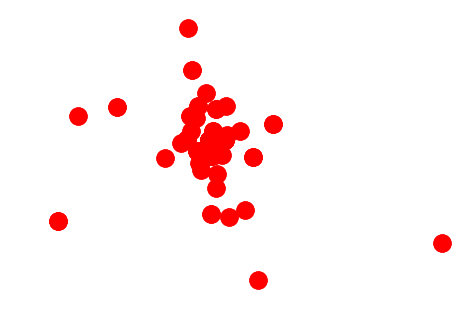

In [276]:
nx.draw_spectral(graph)

In [278]:
nx.draw_networkx_nodes(G = graph, pos = pos, node_list = graph.nodes(),node_color = 'r', alpha = 0.8, node_size = 100)
nx.draw_networkx_edges(G = graph, pos = pos, edge_color='g', alpha=0.2, arrows = False)

TypeError: draw_networkx_nodes() takes at least 2 arguments (4 given)

In [252]:
dr

<module 'networkx' from '/Users/kanaaax/anaconda2/lib/python2.7/site-packages/networkx/__init__.pyc'>

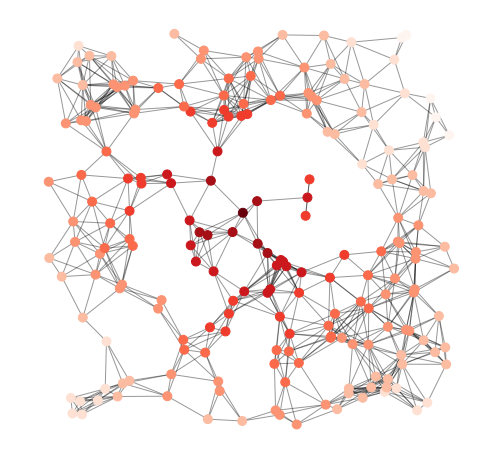

In [6]:
import networkx as nx
import matplotlib.pyplot as plt

G=nx.random_geometric_graph(200,0.125)
# position is stored as node attribute data for random_geometric_graph
pos=nx.get_node_attributes(G,'pos')

# find node near center (0.5,0.5)
dmin=1
ncenter=0
for n in pos:
    x,y=pos[n]
    d=(x-0.5)**2+(y-0.5)**2
    if d<dmin:
        ncenter=n
        dmin=d

# color by path length from node near center
p=nx.single_source_shortest_path_length(G,ncenter)

plt.figure(figsize=(8,8))
nx.draw_networkx_edges(G,pos,nodelist=[ncenter],alpha=0.4)
nx.draw_networkx_nodes(G,pos,nodelist=p.keys(),
                       node_size=80,
                       node_color=p.values(),
                       cmap=plt.cm.Reds_r)

plt.xlim(-0.05,1.05)
plt.ylim(-0.05,1.05)
plt.axis('off')
plt.show()

In [344]:
import networkx as nx 
ints   = pd.read_csv('/Users/kanaaax/Desktop/string_ints.tsv', sep='\t')[['#node1', 'node2']]
coords = pd.read_csv('/Users/kanaaax/Desktop/string_coords.txt', sep='\t')[['x_position', 'y_position']]
G = nx.from_pandas_edgelist(ints,'#node1', 'node2')


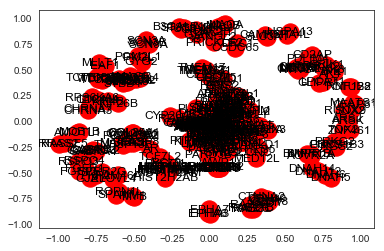

In [350]:
nx.draw_networkx(G)

In [332]:
print len(coords)
print len(ints)


942
753


In [ ]:
pos= nx.get_node_attributes

In [ ]:
pos= nx.get_node_attributes(coords